# Continued pretraining (CP) using Unsloth

In [1]:
#install latest version of unsloth
#%pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

#%pip install --upgrade unsloth
%pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
# %pip install --upgrade unsloth_zoo
# %pip install wandb

Found existing installation: unsloth 2025.3.18
Uninstalling unsloth-2025.3.18:
  Successfully uninstalled unsloth-2025.3.18
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-qo_xz0p1
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-qo_xz0p1
  Resolved https://github.com/unslothai/unsloth.git to commit eefba34e94443971533bffdf2ac32069ed07b0c2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.3.19-py3-none-any.whl size=192249 sha256=c7aa5801276b72e6e75c104e16de19679d3cdbe41260ceedeeabd2c20d2c22a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb7btzxj/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -m xformers.info

xFormers 0.0.29.post3
memory_efficient_attention.ckF:                    unavailable
memory_efficient_attention.ckB:                    unavailable
memory_efficient_attention.ck_decoderF:            unavailable
memory_efficient_attention.ck_splitKF:             unavailable
memory_efficient_attention.cutlassF-pt:            available
memory_efficient_attention.cutlassB-pt:            available
memory_efficient_attention.fa2F@v2.5.7-pt:         available
memory_efficient_attention.fa2B@v2.5.7-pt:         available
memory_efficient_attention.fa3F@0.0.0:             unavailable
memory_efficient_attention.fa3B@0.0.0:             unavailable
memory_efficient_attention.triton_splitKF:         available
indexing.scaled_index_addF:                        available
indexing.scaled_index_addB:                        available
indexing.index_select:                             available
sp24.sparse24_sparsify_both_ways:                  available
sp24.sparse24_apply:                               

In [3]:
!python -m bitsandbytes

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BUG REPORT INFORMATION ++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++ OTHER +++++++++++++++++++++++++++
CUDA specs: CUDASpecs(highest_compute_capability=(8, 0), cuda_version_string='124', cuda_version_tuple=(12, 4))
PyTorch settings found: CUDA_VERSION=124, Highest Compute Capability: (8, 0).
To manually override the PyTorch CUDA version please see: https://github.com/TimDettmers/bitsandbytes/blob/main/docs/source/nonpytorchcuda.mdx
The directory listed in your path is found to be non-existent: /mnt/personal/mlynatom/.vscode-server/.vscode-server/extensions/ms-python.debugpy-2025.4.1-linux-x64/.noConfigDebugAdapterEndpoints/endpoint-41cacdfa2708845e.txt
The directory listed in your path is found to be non-existent: /home/mlynatom/.jupyter/lab/workspaces
The directory listed in your path is found to be non-existent: /home/mlynatom/master-thesis-repo

In [1]:
!echo $HF_HOME

/mnt/personal/mlynatom/.cache/huggingface


In [2]:
!echo $NEPTUNE_API_TOKEN

eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MzRjMjcyMS03YTdjLTQ4ZDgtODMzYS1lZmJjMTEyOTA2NTcifQ==


In [3]:
from unsloth import FastLanguageModel, is_bfloat16_supported

from unsloth import UnslothTrainingArguments, UnslothTrainer
from datasets import load_dataset

import torch

# random state
SEED = 42

# reproducibility
## torch
torch.manual_seed(SEED)

## python
import random
random.seed(SEED)

## numpy
import numpy as np
np.random.seed(SEED)

## 🧠 Load Model

In [10]:
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model_id = "meta-llama/Llama-3.1-8B"

#model_id = "meta-llama/Llama-3.2-3B"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Init LoRA

In [5]:
from peft import LoftQConfig

"""
    This is the sub-configuration class to store the configuration of a [`LoraModel`].

    Args:
        bits_pattern (`dict`): The mapping from layer names or regexp expression to bits which are different from the
            default bits specified by `bits`. For example, `{model.decoder.layers.0.encoder_attn.k_proj: 2`}.
        bits (`int`): Quantization bits for LoftQ.
        iter (`int`): Alternating iterations for LoftQ.
        fake (`bool`): True: use fp16/fp32; used for first time to save weights. False: use bitsandbytes 4bit linear
            models. weights can't be saved. Recommend to set to True, save the weights and load the saved weights in 4
            bits.
    """

loftq_config = LoftQConfig(loftq_bits=4)

In [11]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 256, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                      "embed_tokens", "lm_head"], #now also embeddings and lm_head
    lora_alpha = 1,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", #"unsloth", # True or "unsloth" for very long context
    random_state = SEED,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = "loftq",
    # loftq_config = loftq_config, # And LoftQ
)

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


## Prepare Data

In [ ]:
# from datasets import load_dataset

# # this dataset has already fixed encoding using ftfy (as is used by me in the preprocessing steps of other datasets)
dataset_cs = load_dataset("HuggingFaceFW/fineweb-2", "ces_Latn", split="train", streaming=True)
#we need only texts
dataset_cs = dataset_cs.remove_columns(["id", "dump", "url", "date", "file_path", "language", "language_score", "language_script", "minhash_cluster_size", "top_langs"])
#shuffle to be sure we select "random sample"
dataset_cs = dataset_cs.shuffle(seed=42)
dataset_cs

In [ ]:
dataset_cs = dataset_cs.take(range(19531250))
dataset_cs

In [ ]:
dataset_torch = dataset_cs.with_format("torch")
dataset_torch

In [ ]:
len(dataset_torch)

In [ ]:
dataset = dataset_torch

In [ ]:
19531250/1024

In [ ]:
dataset_cs = dataset_cs.take(19531250)
dataset_cs

In [ ]:
x=10000000000/512
x

In [ ]:
len(dataset_cs)

In [ ]:
num_all_tokens = len(dataset_cs)*512 #number of tokens when using 512 tokens per data point
num_all_tokens

In [ ]:
#number of tokens per batch (processed in one step)
global_batch_size = 1024

tokens_per_step = global_batch_size*max_seq_length
tokens_per_step

In [ ]:
#number of steps to process 10 B tokens
num_steps = 10e9/tokens_per_step
num_steps

In [ ]:
#determine step number when len of dataset is not available when streaming
len(dataset_cs) / 1024

In [ ]:
# dataset_en = load_dataset("HuggingFaceFW/fineweb-edu", "sample-10BT", split="train")
# dataset_en


In [ ]:
# dataset_en = dataset_en.remove_columns(["id", "dump", "url", "file_path", "language", "language_score", "token_count", "score", "int_score"])
# dataset_en.shuffle(seed=42)
# dataset_en

In [ ]:
# from datasets import concatenate_datasets
# #select 40000 samples (for the initial exp.)

# dataset_cs = dataset_cs.select(range(30000))
# dataset_en = dataset_en.select(range(10000))

# dataset = concatenate_datasets([dataset_cs, dataset_en])
# dataset

In [ ]:
# dataset.save_to_disk("data/pretraining/init_31mix_cs-en")

In [ ]:
# from datasets import load_from_disk
# dataset = load_from_disk("data/pretraining/init_31mix_cs-en")
# dataset

In [ ]:
dataset = dataset_cs

In [ ]:
dataset

In [ ]:
def preprocess_function(examples):
    return {"text": [example + tokenizer.eos_token for example in examples["text"]]}

dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
# for row in dataset[:5]["text"]:
#     print("=========================")
#     print(row)

## Load Prepared Data

In [16]:
from datasets import load_from_disk, load_dataset

dataset = load_from_disk("/mnt/personal/mlynatom/data/pretraining/fineweb-2_ces_Latn_19531250_llama_preprocessed")
#dataset = dataset.take(500000)
dataset = dataset.take(1000)
# dataset = dataset.to_iterable_dataset()
# dataset = dataset.with_format("torch")
dataset

Loading dataset from disk:   0%|          | 0/134 [00:00<?, ?it/s]

Exception ignored in: <function NeptuneCallback.__del__ at 0x7f50769c0400>
Traceback (most recent call last):
  File "/home/mlynatom/master-thesis-repository-tomas-mlynar/venv/master_venv/lib/python3.12/site-packages/transformers/integrations/integration_utils.py", line 1661, in __del__
    if self._volatile_checkpoints_dir is not None:
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NeptuneCallback' object has no attribute '_volatile_checkpoints_dir'


Dataset({
    features: ['text'],
    num_rows: 1000
})

In [15]:
len(tokenizer(dataset[4886]["text"])["input_ids"])

855

In [17]:
#compute on sample average and std of tokenized text lenghts
import numpy as np

lengths = []
for i in range(1000):
    tokenized = tokenizer(dataset[i]["text"])["input_ids"]
    lengths.append(len(tokenized))

np.mean(lengths), np.std(lengths), np.max(lengths), np.min(lengths)


(945.159, 1421.484906609634, 14821, 91)

(array([211., 179., 124., 102.,  90.,  40.,  34.,  29.,  17.,  15.,  17.,
         18.,  19.,  14.,   7.,  11.,   5.,   3.,   5.,  10.,   6.,   1.,
          0.,   4.,   2.,   3.,   1.,   3.,   2.,   3.,   0.,   1.,   2.,
          1.,   0.,   1.,   2.,   2.,   2.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   91. ,   238.3,   385.6,   532.9,   680.2,   827.5,   974.8,
         1122.1,  1269.4,  1416.7,  1564. ,  1711.3,  1858.6,  2005.9,
         2153.2,  2300.5,  2447.8,  2595.1,  2742.4,  2889.7,  3037. ,
         3184.3,  3331.6,  3478.9,  3626.2,  3773.5,  3920.8,  4068.1,
         4215.4,  4362.7,  4510. ,

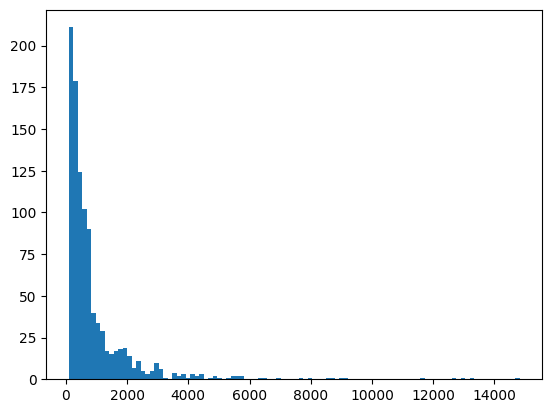

In [23]:
import matplotlib.pyplot as plt

plt.hist(lengths, bins=100)

In [10]:
1953125*42/177

463453.3898305085

In [12]:
500000*1024

512000000

## Train the model

### Trainer Modifications

In [ ]:
class UnslothKLLossTrainer(UnslothTrainer):
    def __init__(self, ref_model, kl_weight=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ref_model = ref_model
        self.ref_model.eval()
        self.kl_weight = kl_weight

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        #account for the actual number of items in the batch
        if num_items_in_batch is not None:
            effective_batch_size = num_items_in_batch
        else:
            effective_batch_size = labels.size(0)
        
        #cross entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction="sum")
        loss_ce = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))
        loss_ce = loss_ce / effective_batch_size # Scale by actual number of items

        # KL loss
        with torch.no_grad():
            ref_outputs = self.ref_model(**inputs)
            ref_logits = ref_outputs.logits
        
        loss_kl_fct = torch.nn.KLDivLoss(reduction="sum")
        loss_kl = loss_kl_fct(
            torch.nn.functional.log_softmax(logits, dim=-1),
            torch.nn.functional.softmax(ref_logits, dim=-1),
        )
        loss_kl = loss_kl / effective_batch_size # Scale by actual number of items

        total_loss = loss_ce + self.kl_weight*loss_kl

        return (total_loss, outputs) if return_outputs else total_loss

from transformers.utils.import_utils import is_torch_xla_available
#from transformers.trainer_utils import SaveStrategy
from typing import Dict
import numpy as np

class PerplexityTrainer(UnslothTrainer):
    # def training_step(self, model, inputs, num_items_in_batch):
    #     loss = super().training_step(model, inputs, num_items_in_batch)

    #     # log perplexity
    #     perplexity = torch.exp(loss)
    #     self.log({"train_perplexity": perplexity})

    #     return loss
    def _maybe_log_save_evaluate(self, tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log and self.state.global_step > self._globalstep_last_logged:
            if is_torch_xla_available():
                xm.mark_step()

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss

            loss = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["loss"] = loss

            #PERPLEXITY
            logs["perplexity"] = round(float(np.exp(tr_loss_scalar)), 4)
            #########################


            if grad_norm is not None:
                logs["grad_norm"] = grad_norm.detach().item() if isinstance(grad_norm, torch.Tensor) else grad_norm
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            metrics = self._evaluate(trial, ignore_keys_for_eval)

        if self.control.should_save:
            self._save_checkpoint(model, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

TrainerClass = PerplexityTrainer

In [ ]:
from transformers import EvalPrediction
import numpy as np

#prepare perplexity computation
def compute_metrics(pred: EvalPrediction):
    losses = pred.losses

    mean_loss = np.mean(losses)

    try:
        perplexity = np.exp(mean_loss)
    except OverflowError:
        perplexity = float("inf")

    return {"perplexity": perplexity}


In [ ]:
from datasets import load_dataset
import random
import numpy as np
from peft import LoftQConfig, get_peft_model, LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import SFTTrainer, SFTConfig
from typing import Optional
from dataclasses import dataclass, field
from transformers import TrainingArguments
import torch


def _create_unsloth_optimizer(
    model,
    optimizer_cls,
    optimizer_kwargs,
    embedding_lr = 5e-5,
):
    lr = optimizer_kwargs["lr"]
    weight_decay = optimizer_kwargs.get("weight_decay", 0.0)

    param_groups = \
    {
        "non_embeddings" : {},
        "embeddings"     : {},
    }

    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        if name.endswith("modules_to_save.default.weight"):
            partial_name = name[:-len(".modules_to_save.default.weight")]
            partial_name = partial_name[partial_name.rfind(".")+1:]
            print(f"Unsloth: Setting lr = {embedding_lr:.2e} instead of {lr:.2e} for {partial_name}.")
            param_groups["embeddings"]    [name] = param
        else:
            param_groups["non_embeddings"][name] = param
        pass
    pass

    optimizer_grouped_parameters = [
        {
            "params"       : list(param_groups["non_embeddings"].values()),
            "weight_decay" : weight_decay,
            "lr"           : lr,
        },
        {
            "params"       : list(param_groups["embeddings"].values()),
            "weight_decay" : weight_decay,
            "lr"           : embedding_lr,
        },
    ]
    optimizer = optimizer_cls(optimizer_grouped_parameters, **optimizer_kwargs)
    return optimizer

@dataclass
class UnslothTrainingArguments(SFTConfig):
    embedding_learning_rate : Optional[float] = field(
        default = None,
        metadata = {"help" : "Different learning rates for embeddings and lm_head."}
    )

class UnslothTrainer(SFTTrainer):
    def create_optimizer(self):
        embedding_learning_rate = getattr(self.args, "embedding_learning_rate", None)
        if embedding_learning_rate is None: return super().create_optimizer()

        if self.optimizer is None:
            optimizer_cls, optimizer_kwargs = SFTTrainer.get_optimizer_cls_and_kwargs(self.args)
            self.optimizer = _create_unsloth_optimizer(
                self.model,
                optimizer_cls,
                optimizer_kwargs,
                embedding_learning_rate,
            )
        
        return self.optimizer

### Training

In [ ]:
#!export WANDB_NO_VERIFY=true

In [20]:
import os
os.environ["NEPTUNE_PROJECT"] = "mlynatom/cp-exp"  # replace with your own

In [18]:
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    
    # ref_model=copy.deepcopy(model),
    #compute_metrics=compute_metrics,
    #packing=True,
    
    args = UnslothTrainingArguments(
        dataset_text_field = "text",
        max_seq_length = max_seq_length,
        dataset_num_proc = 8,
        packing=False,
        #group_by_length = True,
        per_device_train_batch_size = 64,
        gradient_accumulation_steps = 16,
        warmup_ratio = 0.05,
        num_train_epochs = 1, # Set this for 1 full training run. - not supported for streaming -> use max_steps (here 61234=dataset_len/global_batch_size)
        #max_steps = 10,
        learning_rate = 5e-4,
        embedding_learning_rate = 5e-4/2,
        #fp16 = not is_bfloat16_supported(),
        bf16 = True,
        #tf32 = True,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = SEED,
        output_dir = "outputs",
        report_to = "neptune", # Use this for WandB etc
        run_name="llama3.1-8b-cp-exp-loftq_final",
        # eval_strategy = "steps",
        # eval_steps = 50,
        save_strategy = "steps",
        save_steps = 100,
        save_total_limit = 2,
    ),
)

Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
#Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.254 GB.
17.877 GB of memory reserved.


In [8]:
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True,
    #with_stack=True
) as prof:
    # Run training step
    trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500,000 | Num Epochs = 1 | Total steps = 488
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 16 x 1) = 1,024
 "-____-"     Trainable parameters = 1,721,761,792/9,752,023,040 (17.66% trained)


Unsloth: Will smartly offload gradients to save VRAM!


KeyboardInterrupt: 

In [22]:
%pip install psutil

Note: you may need to restart the kernel to use updated packages.


In [21]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 16 x 1) = 1,024
 "-____-"     Trainable parameters = 1,721,761,792/8,000,000,000 (21.52% trained)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mlynatom/cp-exp/e/CPEX-1
Unsloth: Will smartly offload gradients to save VRAM!


KeyboardInterrupt: 

In [9]:
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         0.03%      63.298ms        25.69%       50.175s       3.287ms       0.000us         0.00%      119.106s       7.803ms           0 b           0 b    3987.01 Gb           0 

In [ ]:
#64
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#16
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#8
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#4
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#16*16 - a100 40GB
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#16*16 - 80GB
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#128 *2 - 40 + group by length
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#128 *2 - 40 + packing
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#128 *2 - 40
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#256
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#plot spent time

prof.export_memory_timeline("memory_timeline.html")

In [ ]:
print(prof.key_averages().table(sort_by="cpu_memory_usage"))

In [ ]:
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
print(prof.key_averages().table(sort_by="cuda_memory_usage"))

In [ ]:
#Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")